# Generative Adverserial Networks (GANs)


## 1. Mounting Drive and Loading Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image,make_grid
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms.transforms import Grayscale
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchsummary import summary
import numpy as np
import torchvision.utils as vutils
import pickle


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Loading Dataset and Preprocess

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, main_dir=None, dim = 28, transform=None):
        self.main_dir = main_dir
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                      transforms.Grayscale(1),
                                      transforms.Resize(dim),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=0.5, std=0.5)
                                      ])
        self.total_imgs = os.listdir(main_dir)
        # print(self.total_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        # print(self.total_imgs[idx])
        img_loc = self.main_dir+ self.total_imgs[idx]
        # print(img_loc)
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image, torch.tensor(0)

torch.Size([1, 200, 200])


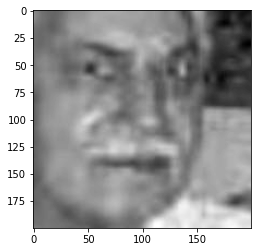

In [ ]:
dim = 200
dataset = FaceDataset('/content/drive/MyDrive/UTKFace/',dim=dim)
plt.imshow(dataset[0][0].squeeze(),cmap='gray')
print(dataset[0][0].shape)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
print(f"Number of batches: {len(dataloader)}")

Number of batches: 223


## 3. Discriminator Model

In [ ]:
class Discriminator(nn.Module):

    def __init__(self,dim=28):
        super(Discriminator, self).__init__()
        n_features = dim*dim
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.5),
            nn.Dropout(0.25)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.5),
            nn.Dropout(0.25)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.5),
            nn.Dropout(0.25)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.5),
            nn.Dropout(0.25)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

## 4. Generator Model

In [ ]:
class Generator(nn.Module):
    def __init__(self,dim=28):
        super(Generator, self).__init__()
        n_features = 100
        n_out = dim*dim
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.5)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.5)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.5)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## 5. GAN Trainer for People's Faces

In [ ]:
class GanTrainer():
  def __init__(
        self,
        device,
        dim=200,
        num_epochs=50,
        lr=0.0002,
        path='data/'
      ) -> None:
      self.discriminator_model = Discriminator(dim).to(device)
      self.generator_model = Generator(dim).to(device)
      self.discriminator_optimizer = optim.Adam(self.discriminator_model.parameters(), lr=lr)
      self.generator_optimizer = optim.Adam(self.generator_model.parameters(), lr=lr)
      self.loss = nn.BCELoss()#.to(device)
      self.device = device
      self.dim = dim
      self.num_epochs = num_epochs
      self.lr = lr
      self.discriminator_losses = []
      self.generator_losses = []
      self.discriminator_epoch_losses = []
      self.generator_epoch_losses = []
      self.fake_images = []
      self.path = path
      pass
  
  def images_to_vectors(self, images):
    return images.view(images.size(0), self.dim*self.dim)
  
  def vectors_to_images(self, vectors):
    return vectors.view(vectors.size(0), 1, self.dim, self.dim)

  def noise(self, size):
    return torch.randn(size, 100).to(self.device)
  
  def ones_target(self, size):
    return torch.ones(size, 1).to(self.device) 
  
  def zeros_target(self, size):
    return torch.zeros(size, 1).to(self.device)

  def train_discriminator(
      self, 
      real_data, 
      real_targets, 
      fake_data, 
      fake_targets
      ):
    self.discriminator_optimizer.zero_grad()
    prediction_real = self.discriminator_model(real_data)
    loss_real = self.loss(prediction_real, real_targets)
    loss_real.backward()

    prediction_fake = self.discriminator_model(fake_data)
    loss_fake = self.loss(prediction_fake, fake_targets)
    loss_fake.backward()
    self.discriminator_optimizer.step()
    
    return loss_real + loss_fake, prediction_real, prediction_fake

  def train_generator(self, fake_data, real_targets):
    self.generator_optimizer.zero_grad()   
    prediction = self.discriminator_model(fake_data)
    # because we have 1-D(G(z)), so this is why we used that.
    loss = self.loss(prediction, real_targets)
    loss.backward()
    self.generator_optimizer.step()
    return loss


  def mean(self, array):
    return sum(array)/len(array)

  
  def train(self, real_dataloader, verbose=True):
    for epoch in range(self.num_epochs):
      discriminator_local_losses = []
      generator_local_losses = []
      self.generator_model.train()
      for real_images, _ in real_dataloader:
        real_images_count = real_images.size(0)
        real_data = self.images_to_vectors(real_images).to(device)
        real_targets = self.ones_target(real_images_count)

        noises = self.noise(real_images_count)
        fake_data = self.generator_model(noises)
        fake_targets = self.zeros_target(real_images_count)

        d_loss, d_pred_real, d_pred_fake = self.train_discriminator(real_data, 
                                                                real_targets, 
                                                                fake_data, 
                                                                fake_targets)
        
        # generate new fake data with the same count as real_images_count
        noises = self.noise(real_images_count)
        fake_data = self.generator_model(noises)
        g_loss = self.train_generator(fake_data, real_targets)

        self.discriminator_losses.append(d_loss.item())
        discriminator_local_losses.append(d_loss.item())

        self.generator_losses.append(g_loss.item())
        generator_local_losses.append(g_loss.item())
      
      discriminator_epoch_loss = self.mean(discriminator_local_losses)
      self.discriminator_epoch_losses.append(discriminator_epoch_loss)
      generator_epoch_loss = self.mean(generator_local_losses)
      self.generator_epoch_losses.append(generator_epoch_loss)
      if epoch % 5 == 0:
        print("epoch: ", epoch)
        self.generate_image()
  

  def plot_epoch_losses(self, skip=0):
    space = np.arange(len(self.discriminator_epoch_losses[skip:]))
    plt.plot(space,np.array(self.generator_epoch_losses[skip:]),label="Generator")
    plt.plot(space,np.array(self.discriminator_epoch_losses[skip:]),
             label="Discriminator ")
    plt.legend()
    plt.show()

  
  def plot_losses(self, skip=0):
    space = np.arange(len(self.discriminator_losses[skip:]))
    plt.plot(space,np.array(self.generator_losses[skip:]),label="Generator")
    plt.plot(space,np.array(self.discriminator_losses[skip:]),label="Discriminator ")
    plt.legend()
    plt.show()

  def generate_image(self):
    with torch.no_grad():
      self.generator_model.eval()
      fake_image = self.generator_model(self.noise(10))
      fake_image = self.vectors_to_images(fake_image)
      plt.figure(figsize=(6,1))
      # array of images to save
      images = []
      for i in range(6):
        plt.subplot(1,6,i+1)
        images_to_show = np.transpose(
            vutils.make_grid(
                fake_image[i][:10], 
                padding=0, normalize=True, 
                interpolation='nearest').cpu(),
            (1,2,0))
        images.append(images_to_show)
        plt.imshow(images_to_show)
        plt.axis('off')
      plt.savefig(f"{self.path}samples_{len(self.generator_epoch_losses)}_{self.lr}.png")
      plt.show()
      # append them to all previous images
      self.fake_images.append(images)
  
  def save(self):
    with open(f"{self.path}data_{len(self.generator_epoch_losses)}_{self.lr}.pkl", 'wb') as handle:
      data_to_save = [      
                      self.discriminator_losses,
                      self.generator_losses,
                      self.discriminator_epoch_losses,
                      self.generator_epoch_losses,
                      self.fake_images,
                      ]
      pickle.dump(data_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 6. Training Process


### 6.1. Evaluating the Model for LR=0.0002 and 100 Epochs
We used the resulting information for our presentation.

epoch:  0


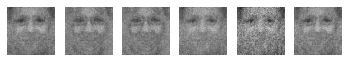

epoch:  5


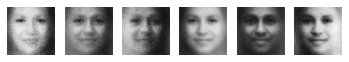

epoch:  10


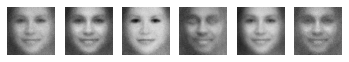

epoch:  15


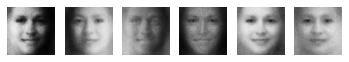

epoch:  20


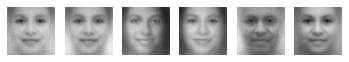

epoch:  25


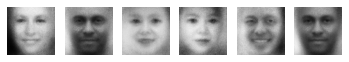

epoch:  30


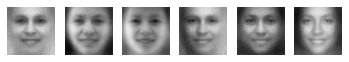

epoch:  35


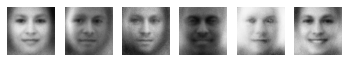

epoch:  40


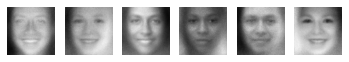

epoch:  45


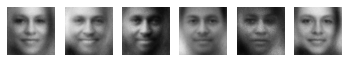

epoch:  50


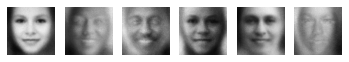

epoch:  55


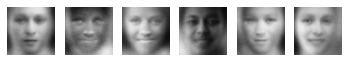

epoch:  60


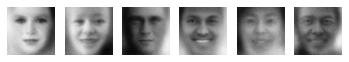

epoch:  65


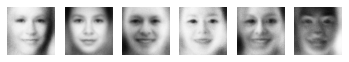

epoch:  70


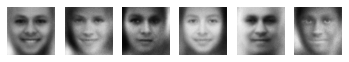

epoch:  75


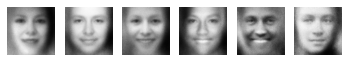

epoch:  80


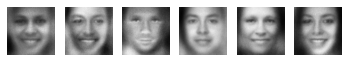

epoch:  85


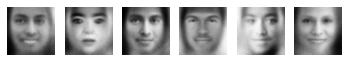

epoch:  90


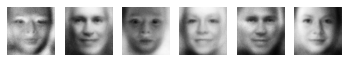

epoch:  95


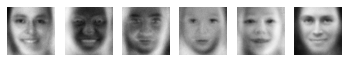

epoch:  100


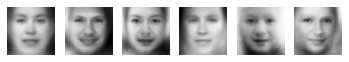

In [ ]:
trainer0002 = GanTrainer(device, dim=dim, num_epochs=101, lr=0.0002)
trainer0002.train(dataloader)
trainer0002.save()

### 6.2. Evaluating the Model for LR=0.001 and 50 Epochs


epoch:  0


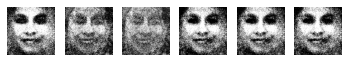

epoch:  5


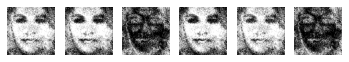

epoch:  10


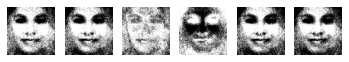

epoch:  15


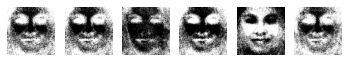

epoch:  20


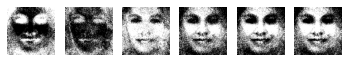

epoch:  25


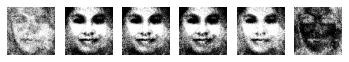

epoch:  30


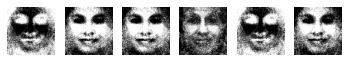

epoch:  35


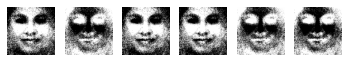

epoch:  40


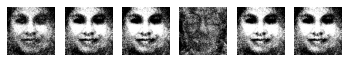

epoch:  45


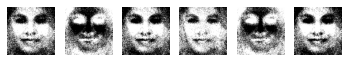

epoch:  50


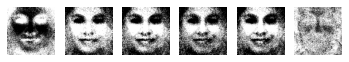

In [ ]:
trainer001 = GanTrainer(device, dim=dim, num_epochs=51, lr=0.001)
trainer001.train(dataloader)
trainer001.save()

### 6.3. Evaluating the Model for LR=0.0001 and 50 Epochs

epoch:  0


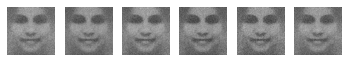

epoch:  5


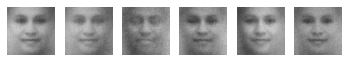

epoch:  10


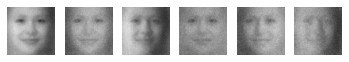

epoch:  15


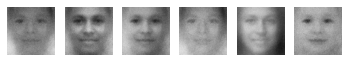

epoch:  20


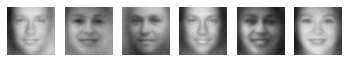

epoch:  25


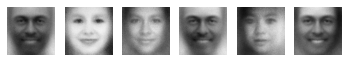

epoch:  30


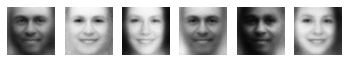

epoch:  35


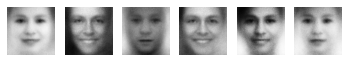

epoch:  40


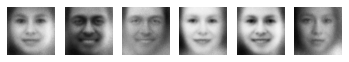

epoch:  45


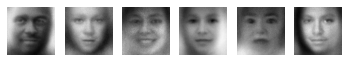

epoch:  50


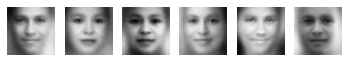

In [ ]:
trainer0001 = GanTrainer(device, dim=dim, num_epochs=51, lr=0.0001)
trainer0001.train(dataloader)
trainer0001.save()

### 6.4. Evaluating the Model for LR=0.00005 and 50 Epochs

epoch:  0


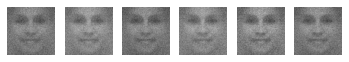

epoch:  5


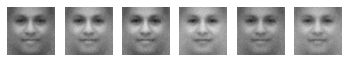

epoch:  10


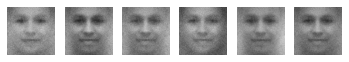

epoch:  15


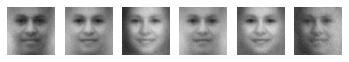

epoch:  20


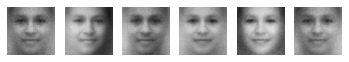

epoch:  25


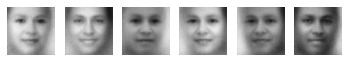

epoch:  30


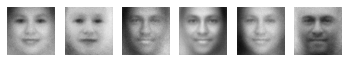

epoch:  35


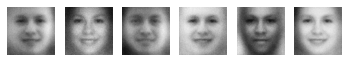

epoch:  40


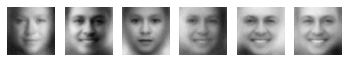

epoch:  45


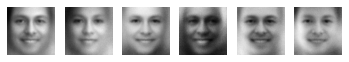

epoch:  50


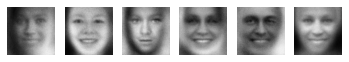

In [ ]:
trainer00005 = GanTrainer(device, dim=dim, num_epochs=51, lr=0.00005)
trainer00005.train(dataloader)
trainer00005.save()

### 6.5. Evaluating the Model for LR=0.00001 and 50 Epochs

epoch:  0


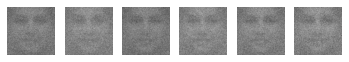

epoch:  5


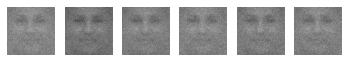

epoch:  10


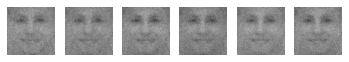

epoch:  15


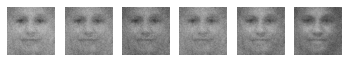

epoch:  20


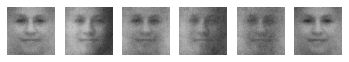

epoch:  25


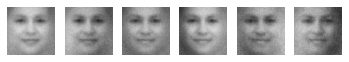

epoch:  30


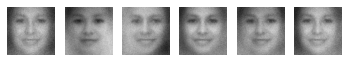

epoch:  35


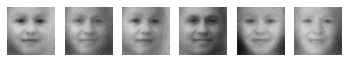

epoch:  40


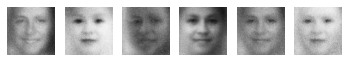

epoch:  45


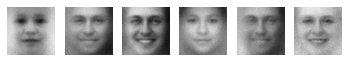

epoch:  50


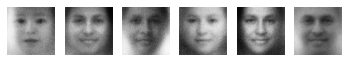

In [ ]:
trainer00001 = GanTrainer(device, dim=dim, num_epochs=51, lr=0.00001)
trainer00001.train(dataloader)
trainer00001.save()

# 7. Results Assessment

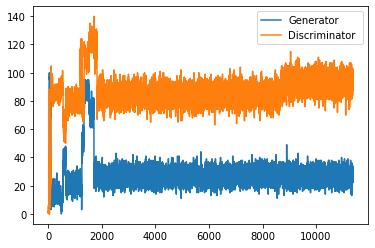

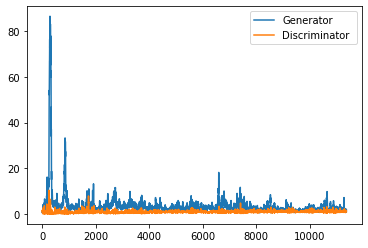

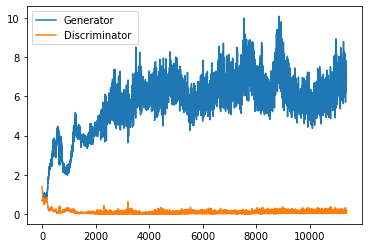

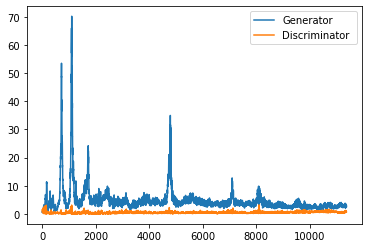

In [ ]:
for trainer_instance in [trainer001, trainer0001, trainer00001, trainer00005]:
  trainer_instance.plot_losses(0)


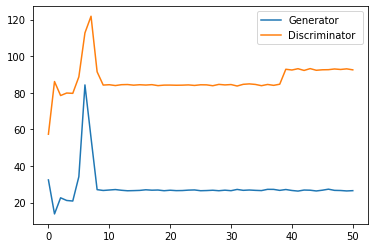

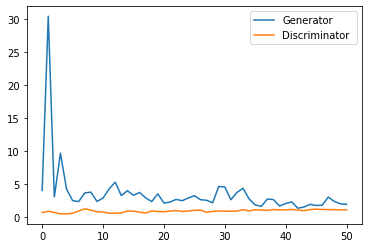

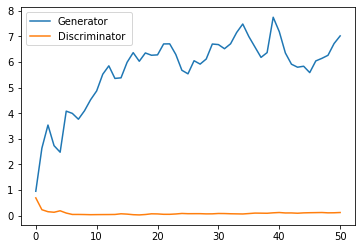

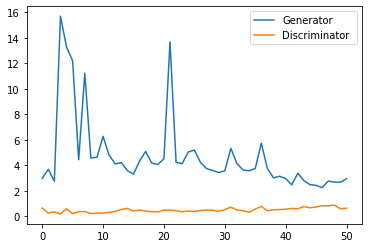

In [ ]:
for trainer_instance in [trainer001, trainer0001, trainer00001, trainer00005]:
  trainer_instance.plot_epoch_losses(0)

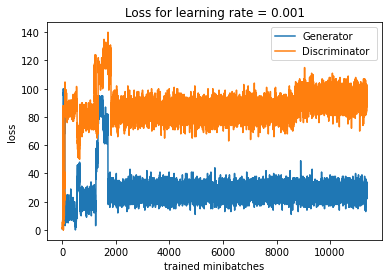

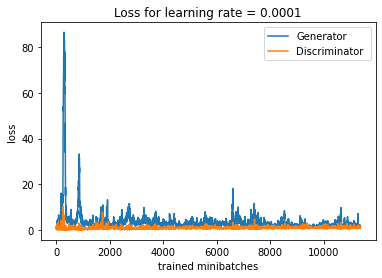

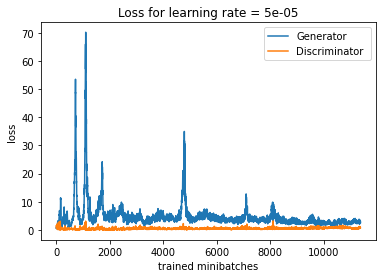

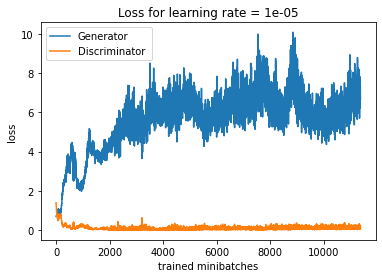

In [ ]:
for trainer_instance in [trainer001, trainer0001, trainer00005, trainer00001]:
  lr = trainer_instance.lr
  space = np.arange(len(trainer_instance.discriminator_losses))
  plt.plot(space,np.array(trainer_instance.generator_losses),label="Generator")
  plt.plot(space,np.array(trainer_instance.discriminator_losses),label="Discriminator ")
  plt.legend()
  plt.xlabel('trained minibatches')
  plt.ylabel('loss')
  plt.title(f"Loss for learning rate = {lr}")
  plt.savefig(f"data/lr_minibatch_{lr}.png")
  plt.show()



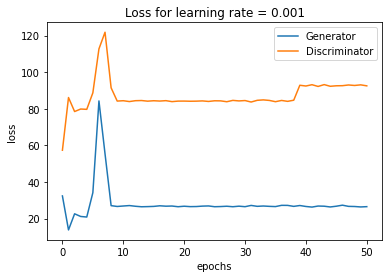

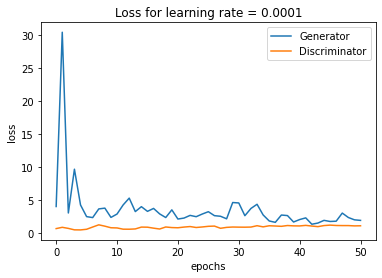

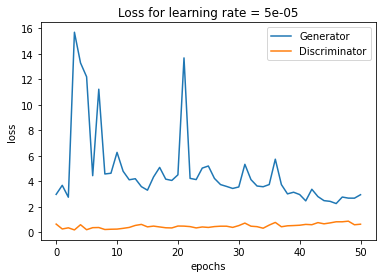

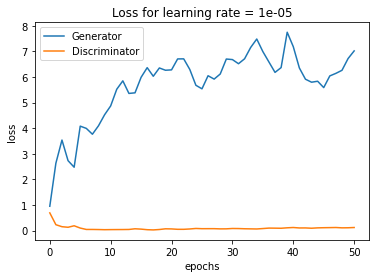

In [ ]:
for trainer_instance in [trainer001, trainer0001, trainer00005, trainer00001]:
  lr = trainer_instance.lr
  space = np.arange(len(trainer_instance.discriminator_epoch_losses))
  plt.plot(space,np.array(trainer_instance.generator_epoch_losses),label="Generator")
  plt.plot(space,np.array(trainer_instance.discriminator_epoch_losses),label="Discriminator")
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title(f"Loss for learning rate = {lr}")
  plt.savefig(f"lr_epoch_{lr}.png")
  plt.show()

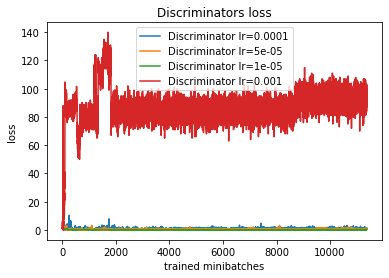

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001, trainer001]:
  space = np.arange(len(trainer_instance.discriminator_losses))
  plt.plot(space,np.array(trainer_instance.discriminator_losses),label=f"Discriminator lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('trained minibatches')
plt.ylabel('loss')
plt.title('Discriminators loss')
plt.savefig(f"data/discriminators_minibatch_loss.png")
plt.show()

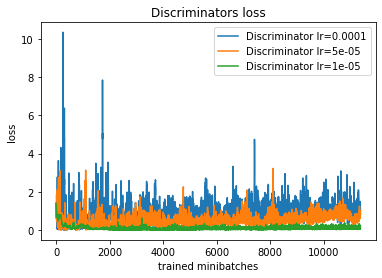

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001]:
  space = np.arange(len(trainer_instance.discriminator_losses))
  plt.plot(space,np.array(trainer_instance.discriminator_losses),label=f"Discriminator lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('trained minibatches')
plt.ylabel('loss')
plt.title('Discriminators loss')
plt.savefig(f"data/discriminators_minibatch_loss_2.png")
plt.show()

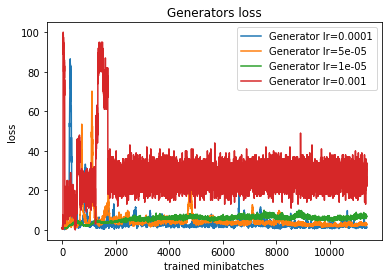

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001, trainer001]:
  space = np.arange(len(trainer_instance.generator_losses))
  plt.plot(space,np.array(trainer_instance.generator_losses),label=f"Generator lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('trained minibatches')
plt.ylabel('loss')
plt.title('Generators loss')
plt.savefig(f"data/generators_minibatch_loss.png")
plt.show()

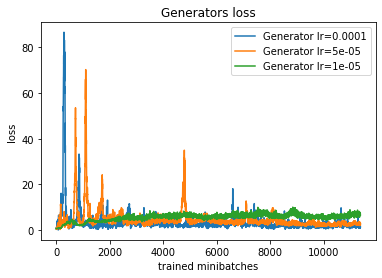

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001]:
  space = np.arange(len(trainer_instance.generator_losses))
  plt.plot(space,np.array(trainer_instance.generator_losses),label=f"Generator lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('trained minibatches')
plt.ylabel('loss')
plt.title('Generators loss')
plt.savefig(f"data/generators_minibatch_loss_2.png")
plt.show()

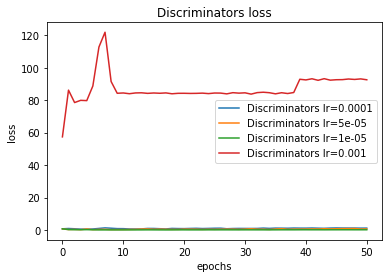

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001, trainer001]:
  space = np.arange(len(trainer_instance.discriminator_epoch_losses))
  plt.plot(space,np.array(trainer_instance.discriminator_epoch_losses),label=f"Discriminators lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Discriminators loss')
plt.savefig(f"data/discriminator_loss.png")
plt.show()

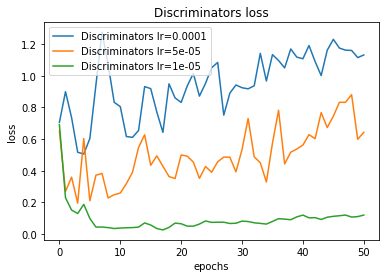

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001]:
  space = np.arange(len(trainer_instance.discriminator_epoch_losses))
  plt.plot(space,np.array(trainer_instance.discriminator_epoch_losses),label=f"Discriminators lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Discriminators loss')
plt.savefig(f"data/discriminator_loss_2.png")
plt.show()

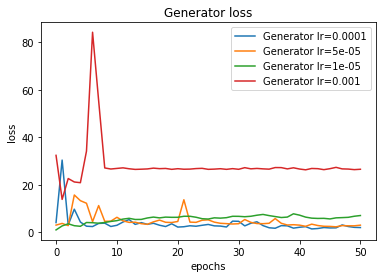

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001, trainer001]:
  space = np.arange(len(trainer_instance.generator_epoch_losses))
  plt.plot(space,np.array(trainer_instance.generator_epoch_losses),label=f"Generator lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Generator loss')
plt.savefig(f"data/generators_loss.png")
plt.show()

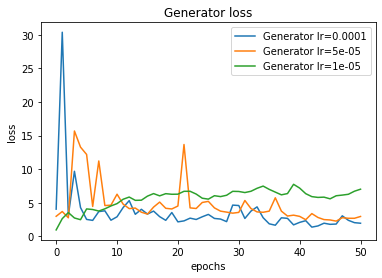

In [ ]:
for trainer_instance in [trainer0001, trainer00005, trainer00001]:
  space = np.arange(len(trainer_instance.generator_epoch_losses))
  plt.plot(space,np.array(trainer_instance.generator_epoch_losses),label=f"Generator lr={trainer_instance.lr}")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Generator loss')
plt.savefig(f"data/generators_loss_2.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


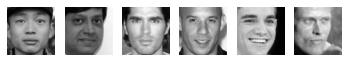

In [ ]:
real_image, _ = next(iter(dataloader))
plt.figure(figsize=(6,1))
for k in range(1,6):
  for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(np.transpose(vutils.make_grid(real_image[i][:10], padding=0, normalize=True, interpolation='nearest').cpu(),(1,2,0)))
    plt.axis('off')
  plt.savefig(f"data/real_image_{k}.png")
plt.show()

In [ ]:
!zip -r /content/data.zip /content/data

updating: content/data/ (stored 0%)
updating: content/data/samples_51_0.001.png (deflated 7%)
updating: content/data/samples_11_5e-05.png (deflated 3%)
updating: content/data/samples_41_0.0002.png (deflated 2%)
updating: content/data/samples_1_0.0002.png (deflated 4%)
updating: content/data/data_51_0.0001.pkl (deflated 13%)
updating: content/data/samples_6_1e-05.png (deflated 3%)
updating: content/data/samples_6_0.0001.png (deflated 2%)
updating: content/data/data_101_0.0002.pkl (deflated 12%)
updating: content/data/samples_6_0.001.png (deflated 7%)
updating: content/data/samples_41_0.001.png (deflated 8%)
updating: content/data/samples_1_5e-05.png (deflated 2%)
updating: content/data/samples_56_0.0002.png (deflated 2%)
updating: content/data/samples_51_0.0002.png (deflated 2%)
updating: content/data/samples_16_0.0001.png (deflated 3%)
updating: content/data/samples_21_0.0002.png (deflated 2%)
updating: content/data/samples_31_0.001.png (deflated 8%)
updating: content/data/samples_1_1e

In [ ]:
from google.colab import files
files.download('data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>